# Import Package

In [2]:
## Import Packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

# Import Data

In [5]:
# import data diabetes
dataset = pd.read_csv("https://raw.githubusercontent.com/taqiyyaghazi/knn_diabetes/main/diabetes.csv")

In [6]:
# Melihat 5 data awal
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
dataset['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [9]:
dataset.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

# Data Preparation

## Cek Missing Value

In [10]:
dataset.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## Cek Tipe Data

In [13]:
dataset.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Cek Data Outlier

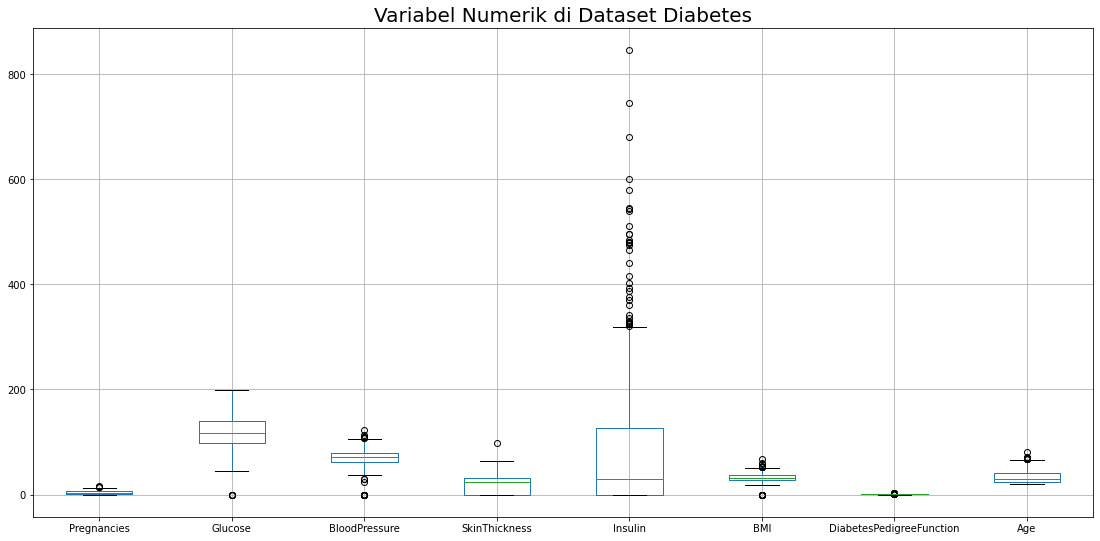

In [15]:
num_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']
plt.figure(figsize=(19,9))
dataset[num_cols].boxplot()
plt.title("Variabel Numerik di Dataset Diabetes", fontsize=20)
plt.show()

# Eksplorasi Data


In [ ]:
# Mencari ukuran data
data.shape

(768, 9)

In [ ]:
# Cek missing value
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
# Cek tipe data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
# Menganalisis data
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
# Inisiasi variabel independen dan dependen
X = data.drop('Outcome', axis=1)
y = data['Outcome']

In [ ]:
# Mengubah data outlier
X.replace(to_replace=0, value=X.mean(), inplace=True)

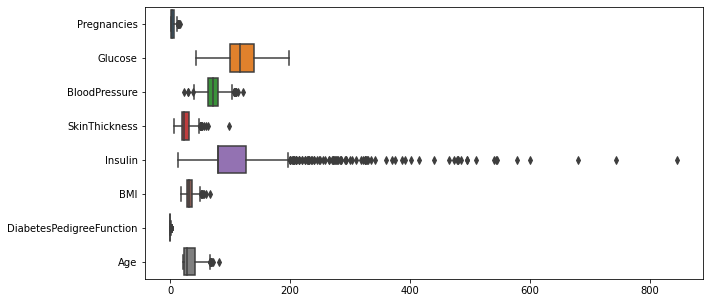

In [ ]:
#Mengecek Outliers menggunakan bloxplot
plt.figure(figsize=(10,5))
sns.boxplot(data=X, orient='h')
plt.show()

# Data Split


In [ ]:
# Import fungsi train_test_split 
from sklearn.model_selection import train_test_split

# Membagi dataset ke training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101) # 70% training and 30% test

# Standart Scaler

In [ ]:
# Import modul standardscaler
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

In [ ]:
# Melakukan standar scaller pada data X train dan X test
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [ ]:
# Hasil dari Standar Scaler X train
X_train_std

array([[-0.81089478, -0.94320345, -0.67501765, ...,  0.77641365,
         0.62083528, -0.86196915],
       [-0.12231061,  2.06645544,  0.47764539, ...,  0.63250137,
        -0.64915711, -0.19012014],
       [-0.81089478,  0.11513814, -1.00434995, ...,  0.17198206,
        -1.19432458, -0.19012014],
       ...,
       [-1.15518687, -0.08330091, -2.32167913, ...,  0.41663294,
        -0.59959643, -0.6940069 ],
       [ 0.22198148, -0.21559361,  0.31297924, ..., -0.20218987,
        -0.40445126,  0.9016345 ],
       [ 1.59914984,  0.28050401, -0.1810192 , ...,  0.22954698,
         0.55268935,  0.98561563]])

In [ ]:
# Hasil dari Standar Scaler X Test
X_test_std

array([[-1.15518687,  0.14821131, -1.00434995, ..., -0.36049338,
        -0.38586601,  1.15357788],
       [-0.46660269,  2.16567496, -0.1810192 , ...,  0.546154  ,
        -0.203111  ,  0.22978549],
       [ 0.91056566, -0.51325218,  1.63030843, ..., -1.42544428,
        -0.73898584,  1.23755901],
       ...,
       [ 0.56627357,  0.41279671, -0.1810192 , ...,  0.40224172,
         0.21195968, -0.35808239],
       [ 1.94344193, -1.77003282,  2.78297147, ...,  0.41663294,
        -0.58410872,  1.15357788],
       [ 3.32061028, -0.71169123,  0.47764539, ...,  0.57493645,
        -0.19072083,  1.06959676]])

# Training Model


In [ ]:
# Import modul KNN
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Melatih model dengan data training
model = KNeighborsClassifier(n_neighbors=21)
model.fit(X_train_std,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                     weights='uniform')

In [ ]:
# Memprediksi data testing dengan model 
y_pred = model.predict(X_test_std)

# Accuracy Score

In [ ]:
#Import modul scikit-learn metrics 
from sklearn import metrics
# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8246753246753247


# Eror Rate

In [ ]:
error = []
iterasi = 40
# Menghitung eror dari K antara 1-40 
for i in range(1, iterasi):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_std, y_train)
    pred_i = knn.predict(X_test_std)
    error.append(np.mean(pred_i != y_test))

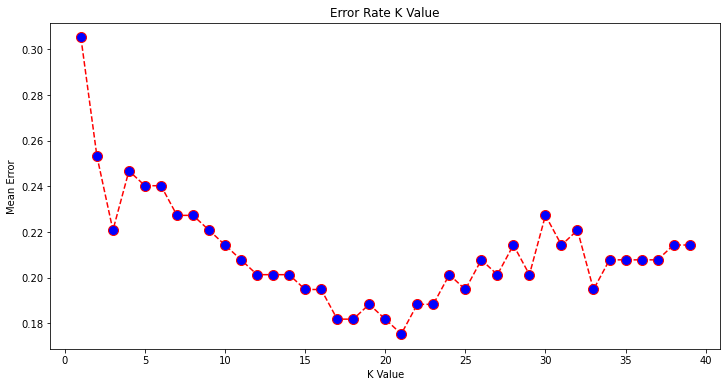

In [ ]:
# Membuat Grafik Eror Rate
plt.figure(figsize=(12, 6))
plt.plot(range(1, iterasi), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()